# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [1]:
from scipy.stats import kurtosis

n_samples = 10000

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [3]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
        # Tecnología y Comunicación
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'AVGO', 'CRM', 'ADBE', 'NFLX',
        # Finanzas
        'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'AXP', 'WFC',
        # Salud
        'JNJ', 'UNH', 'LLY', 'PFE', 'ABBV', 'MRK', 'TMO', 'AMGN',
        # Consumo y Retail
        'WMT', 'COST', 'PG', 'KO', 'PEP', 'NKE', 'MCD', 'SBUX',
        # Energía e Industria
        'XOM', 'CVX', 'CAT', 'GE', 'HON', 'MMM', 'UPS', 'BA',
        # Otros (Inmobiliario, Materiales, Utilities)
        'AMT', 'PLD', 'LIN', 'APD', 'NEE', 'DUK', 'INTC', 'DIS'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

[*********************100%***********************]  50 of 50 completed


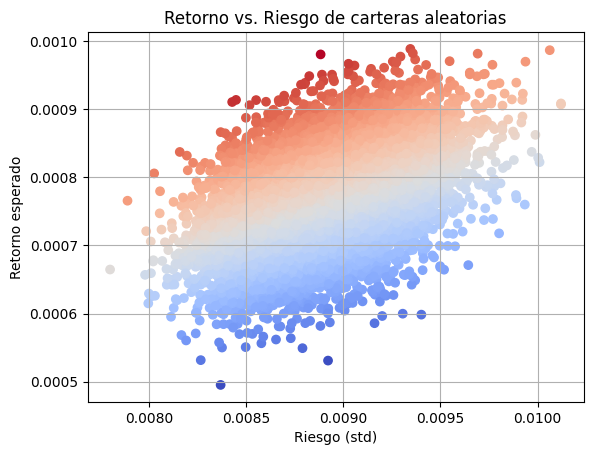

In [4]:

returns = get_data(csv=False)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'MS', 'SBUX', 'V', 'META', 'CRM', 'UNH', 'NKE', 'APD', 'MMM'}
[32, 42, 46, 29, 13, 44, 36, 6, 30]


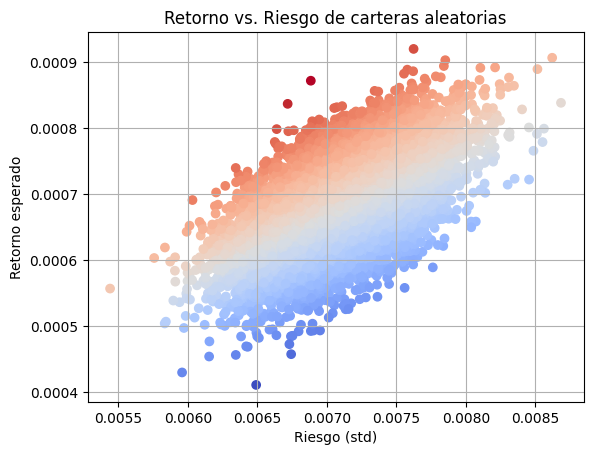

In [5]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 15):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.85) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [6]:
import cvxpy as cp

# Los assets con correlacion inferior al 85% y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

means_max_return = returns_means.max()

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

min_daily_return = 0.0004 # 10% anual

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.15, # No invertimos mas de un 15% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights @ returns_means >= min_daily_return, # Minimo un retorno del 10%
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados
]

results = []
for r_target in np.linspace(returns_means.min(), returns_means.max(), 100):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)

    problem.solve()

    if best_weights.value is not None:
        row = np.concatenate([[portfolio_returns.value], [np.sqrt(portfolio_variance.value)], best_weights.value])
        results.append(row)

columns = ["return", "volatility"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="return", ascending=False)
portfolio_results

,return,volatility,asset0,asset1,asset2,asset3,asset4,asset5,asset6,asset7,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
85,0.002154,0.015199,-4.377525e-06,-3.620732e-06,-1.070222e-05,-4.899871e-06,-6.155023e-06,-3.319699e-06,-5.407168e-09,0.132921,...,-5.132588e-06,-5.097835e-09,-4.915418e-06,-7.692823e-09,-7.234331e-06,-4.761205e-09,-1.255387e-06,0.149999,-3.197979e-06,-6.069292e-06
84,0.002115,0.014581,6.330829e-06,4.114493e-06,1.761640e-05,6.381515e-06,7.325005e-06,5.091338e-06,7.379132e-09,0.096822,...,7.293310e-06,7.396377e-09,7.267653e-06,1.141683e-08,1.153213e-05,6.559878e-09,1.694495e-06,0.149999,3.758157e-06,8.467018e-06
83,0.002075,0.014006,6.310056e-06,1.943951e-06,1.967038e-05,5.144442e-06,6.251552e-06,5.853014e-06,7.185849e-09,0.078462,...,7.274841e-06,8.050017e-09,6.639823e-06,1.091183e-08,1.266431e-05,5.855861e-09,5.825143e-07,0.149997,2.956750e-06,7.592258e-06
82,0.002035,0.013449,-1.851785e-06,-2.931779e-06,-2.738325e-06,-2.884818e-06,-3.973179e-06,-1.026337e-06,-2.844045e-09,0.066612,...,-2.688205e-06,-2.198448e-09,-2.402257e-06,-3.324879e-09,-2.913899e-06,-2.481180e-09,-1.523489e-06,0.149998,-2.621870e-06,-2.978647e-06
81,0.001996,0.012915,-8.036231e-19,-8.374363e-19,-1.975134e-18,-9.119410e-19,-6.645866e-19,-5.847414e-19,-3.718169e-19,0.055839,...,-7.461114e-19,-3.233464e-19,-1.073896e-18,-7.621369e-19,-1.252843e-18,-4.476111e-19,-5.315692e-19,0.150000,-4.888097e-19,-1.159634e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.000686,0.005461,1.746403e-07,-3.339344e-08,-4.150426e-07,2.367821e-08,-4.047287e-07,7.073048e-03,9.917562e-11,0.011364,...,-3.069763e-07,-1.113589e-10,-7.458304e-08,7.010977e-11,1.512248e-05,2.399187e-11,6.995311e-03,0.014630,9.271926e-02,1.000003e-01
0,0.000686,0.005461,1.746403e-07,-3.339344e-08,-4.150426e-07,2.367821e-08,-4.047287e-07,7.073048e-03,9.917562e-11,0.011364,...,-3.069763e-07,-1.113589e-10,-7.458304e-08,7.010977e-11,1.512248e-05,2.399187e-11,6.995311e-03,0.014630,9.271926e-02,1.000003e-01
38,0.000685,0.005461,1.839613e-07,-3.327007e-07,-6.356620e-07,-1.083125e-07,-4.734767e-07,7.065461e-03,-1.117306e-11,0.011362,...,-7.455565e-07,-1.653423e-10,-3.651187e-07,4.887933e-11,1.116806e-05,-6.245006e-11,6.992726e-03,0.014615,9.272252e-02,9.999954e-02
47,0.000685,0.005461,9.540805e-07,-1.203974e-06,-1.364931e-06,-1.494651e-06,-4.206050e-07,7.034026e-03,9.797293e-10,0.011355,...,-2.059012e-06,1.056800e-09,-2.578792e-06,3.237677e-09,7.957062e-06,6.585167e-10,7.005263e-03,0.014548,9.268394e-02,1.000033e-01


In [7]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [8]:
rounded_weights = round_weights(portfolio_results.iloc[0, 2:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)

['0', '0', '0', '0', '0', '0', '0', '0.132', '0', '0', '0', '0.117', '0', '0', '0', '0', '0', '0.15', '0.149', '0.151', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.151', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.15', '0', '0']


In [10]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.000079

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.015656472958002526
